<h1><center>Project 3</center></h1>
<h2><center>Đề tài: Text Classification</center></h2>

# Giới thiệu

Mục tiêu của phân loại văn bản là tự động phân loại tài liệu văn bản thành một hoặc nhiều chủ đề xác định. Một số ví dụ về phân loại văn bản là:
- Hiểu nhu cầu người sử dụng mạng xã hội
- Phát hiện email rác
- Phân loại các bài báo thành chủ đề xác định <br>

Phân loại văn bản là một ví dụ về nhiệm vụ học máy được giám sát vì tập dữ liệu được gắn nhãn chứa tài liệu văn bản và nhãn của chúng được sử dụng để huấn luyện bộ phân loại. Có 4 bước mà chúng ta cần làm như sau:
- Dataset Preparation (Preprocessing Data)
- Feature Engineering (Preprocessing Data)
- Model Training
- Improve Performance <br>

Trong đề tài này, chúng ta sẽ nghiên cứu phân loại bài báo theo chủ đề ứng dụng thuật toán Machine Learing.

# Preprocessing Data

In [1]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP
import pickle
import nltk
from nltk.corpus import stopwords
import os

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn import decomposition, ensemble

#import pandas, numpy, string

## Dataset preparation

+ Vấn đề chính bây giờ là dữ liệu đang ở định dạng văn bản (string). Thuật toán phân loại (classification) chỉ hoạt động dưới dạng dữ liệu số hóa (numeric), từ đó yêu cầu phải chuyển đổi dữ liệu đầu vào trên (chuỗi kí tự) thành vector (chuỗi số) để các thuật toán học máy có thể hiểu được
+ Bước đầu tiên, chia các đoạn tin nhắn thành các từ riêng lẻ, rồi lưu chúng vào list
+ Tách từ trong câu thành từ đơn, từ ghép nhằm tăng ý nghĩa của từ, giảm features. Dùng thư viện underthesea
+ Chuyển các số phần trăm (vd 20%, 10%, 0.5%...) thành 'percents' nhằm giảm features
+ Xóa các kí tự 
+ Chuyển các số thành 'numbers', ngày tháng thành 'days' nhằm giảm features
+ Loại bỏ stopword 

In [2]:
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
dir_path = os.path.join(dir_path, 'ProjectIII\DataDemo')
 
stop_word_list = set(stopwords.words('vietnam'))

def get_data(folder_path):
    X = []
    y = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in tqdm(file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-8") as f:
                lines = f.readlines()
                for i in range(len(lines)):
                    lines[i] = " ".join([word for word in lines[i].split() if word not in stop_word_list])
                lines = ' '.join(lines)
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
                lines = ViTokenizer.tokenize(lines)

                X.append(lines)
                y.append(path)
    return X, y

test_path = os.path.join(dir_path, 'datatest')
X_test, y_test = get_data(test_path)

pickle.dump(X_test, open('DataDemo/X_test.pkl', 'wb'))
pickle.dump(y_test, open('DataDemo/y_test.pkl', 'wb'))

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


In [5]:
train_path = os.path.join(dir_path, 'datatrain')
X_data, y_data = get_data(train_path)

pickle.dump(X_data, open('DataDemo/X_data.pkl', 'wb'))
pickle.dump(y_data, open('DataDemo/y_data.pkl', 'wb'))

100%|██████████| 10/10 [03:46<00:00, 22.65s/it]


## Feature Engineering

Ở bước này, chúng ta sẽ đưa dữ liệu dạng văn bản đã được xử lý về dạng vector thuộc tính có dạng số học:<br>
TF-IDF Vectors sử dụng Word Level

In [2]:
X_data = pickle.load(open('DataDemo/X_data.pkl', 'rb'))
y_data = pickle.load(open('DataDemo/y_data.pkl', 'rb'))

X_test = pickle.load(open('DataDemo/X_test.pkl', 'rb'))
y_test = pickle.load(open('DataDemo/y_test.pkl', 'rb'))

TF(t, d) = (Tần suất xuất hiện của t trong văn bản d) / (Tổng số từ trong văn bản d)<br>
IDF(t) = log(Tổng số văn bản / Số văn bản có chứa t)<br>
TF-IDF = TF(t,d) . IDF(t)

In [3]:
#Chúng ta chọn vector hóa tối đa 30000 từ
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_data) # learn vocabulary and idf from training set
X_data_tfidf =  tfidf_vect.transform(X_data)
X_test_tfidf =  tfidf_vect.transform(X_test)

### Transform by SVD to decrease number of dimensions

In [4]:
from sklearn.decomposition import TruncatedSVD

In [5]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_data_tfidf)

TruncatedSVD(n_components=300, random_state=42)

In [6]:
X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

### Topic Models as features

Topic Modelling là một kỹ thuật để xác định các nhóm từ (được gọi là chủ đề) từ một bộ sưu tập tài liệu chứa thông tin tốt nhất trong bộ sưu tập.

In [7]:
encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_data)
y_test_n = encoder.fit_transform(y_test)

In [8]:
encoder.classes_

array(['Du lich', 'Giai tri', 'Giao duc', 'Kinh doanh', 'Phap luat',
       'Suc khoe', 'The gioi', 'The thao', 'Van hoa', 'Xe'], dtype='<U10')

# Model

Trong hướng dẫn này, chúng ta sẽ triển khai một số mô hình và so sánh chúng để tìm ra mô hình hiệu quả nhất cho bài toán phân loại văn bản. Chúng tôi sẽ thực hiện các mô hình sau:
1. Naive Bayes Classifier
2. Support Vector Machine
3. K-nearest neighbors

Chúng ta sử dụng hàm nguyên mẫu để thực hiện một số phân loại như sau: <br>
(Vì bộ nhớ có hạn, em chỉ thử trên WORD LEVEL TF-IDF (with SVD))

In [18]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from gensim import corpora, matutils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [15]:
class Classifier(object):
    def __init__(self, features_train = None, labels_train = None, features_test = None, labels_test = None,  estimator = None):
        self.features_train = features_train
        self.features_test = features_test
        self.labels_train = labels_train
        self.labels_test = labels_test
        self.estimator = estimator

    def training(self):
        self.estimator.fit(self.features_train, self.labels_train)
        self.__training_result()

    #def save_model(self, filePath):
    #    FileStore(filePath=filePath).save_pickle(obj=est)

    def __training_result(self):
        y_true, y_pred = self.labels_test, self.estimator.predict(self.features_test)
        print(classification_report(y_true, y_pred))
        cnf_matrix = confusion_matrix(y_true, y_pred)
        class_names = ['Du lich', 'Giai tri', 'Giao duc', 'Kinh doanh', 'Phap luat','Suc khoe', 'The gioi', 'The thao', 'Van hoa', 'Xe']
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
        plt.show()
        
        X_train, X_val, y_train, y_val = train_test_split(self.features_train, self.labels_train, test_size=0.1, random_state=42)
        train_predictions = self.estimator.predict(X_train)
        val_predictions = self.estimator.predict(X_val)
        test_predictions = self.estimator.predict(self.features_test)
        print("Train accuracy: ", metrics.accuracy_score(train_predictions, y_train))    
        print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
        print("Test accuracy: ", metrics.accuracy_score(test_predictions, self.labels_test))

## Naive Bayes Classifier

              precision    recall  f1-score   support

     Du lich       0.96      0.90      0.93       300
    Giai tri       0.86      1.00      0.93       300
    Giao duc       0.98      0.95      0.97       300
  Kinh doanh       0.95      1.00      0.97       300
   Phap luat       0.94      1.00      0.97       300
    Suc khoe       0.94      0.99      0.97       300
    The gioi       0.95      0.96      0.96       300
    The thao       0.99      0.98      0.99       300
     Van hoa       0.95      0.78      0.86       300
          Xe       1.00      0.95      0.97       300

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



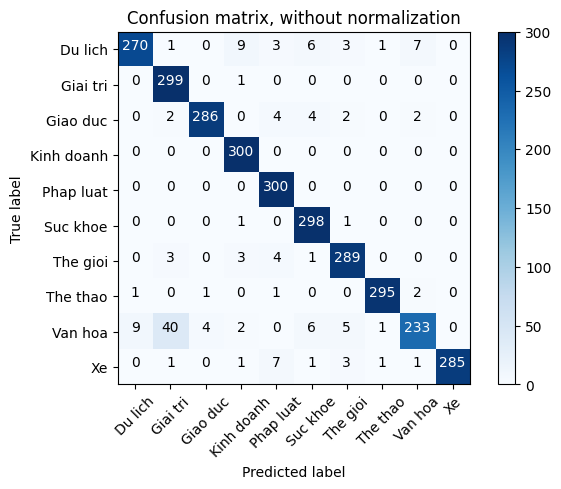

Train accuracy:  0.9424312162951259
Validation accuracy:  0.9363214837712519
Test accuracy:  0.9516666666666667


In [20]:
est = Classifier(features_train=X_data_tfidf, features_test=X_test_tfidf, labels_train=y_data, labels_test=y_test, estimator=naive_bayes.MultinomialNB())
est.training()

## Support Vector Machine

              precision    recall  f1-score   support

     Du lich       0.99      0.90      0.94       300
    Giai tri       0.91      0.80      0.85       300
    Giao duc       0.99      0.97      0.98       300
  Kinh doanh       0.95      1.00      0.98       300
   Phap luat       0.99      1.00      0.99       300
    Suc khoe       0.96      1.00      0.98       300
    The gioi       0.80      0.97      0.88       300
    The thao       0.98      0.98      0.98       300
     Van hoa       0.92      0.87      0.90       300
          Xe       1.00      0.97      0.98       300

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



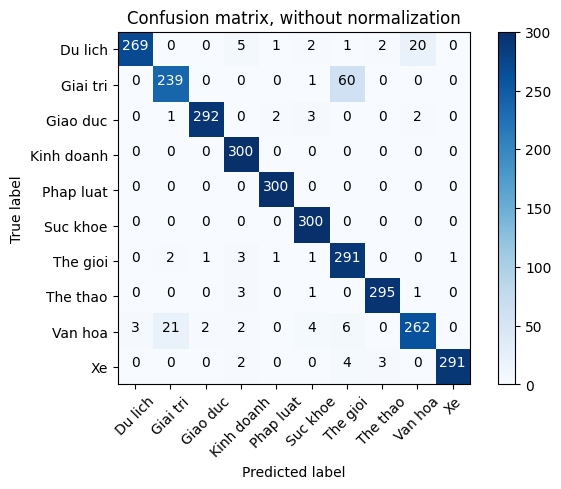

Train accuracy:  0.9665785044481846
Validation accuracy:  0.9616692426584235
Test accuracy:  0.9463333333333334


In [20]:
est = Classifier(features_train=X_data_tfidf_svd, features_test=X_test_tfidf_svd, labels_train=y_data, labels_test=y_test, estimator=svm.SVC())
est.training()

## K-nearest neighbors

              precision    recall  f1-score   support

     Du lich       0.97      0.89      0.93       300
    Giai tri       0.84      0.79      0.82       300
    Giao duc       0.99      0.95      0.97       300
  Kinh doanh       0.97      1.00      0.99       300
   Phap luat       0.97      1.00      0.99       300
    Suc khoe       0.96      1.00      0.98       300
    The gioi       0.80      0.96      0.87       300
    The thao       0.94      0.98      0.96       300
     Van hoa       0.95      0.81      0.87       300
          Xe       1.00      0.97      0.98       300

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.93      3000
weighted avg       0.94      0.94      0.93      3000



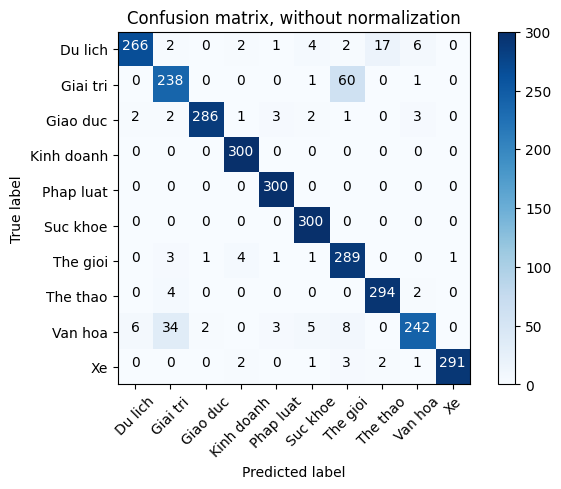

Train accuracy:  0.9576821351286366
Validation accuracy:  0.9474497681607419
Test accuracy:  0.9353333333333333


In [21]:
est = Classifier(features_train=X_data_tfidf_svd, features_test=X_test_tfidf_svd, labels_train=y_data, labels_test=y_test, estimator=KNeighborsClassifier())
est.training()